# Anomaly Detection Tutorial for MUV Dataset
#### 제작 : 허종국 (hjkso1406@korea.ac.kr)

## Introduction
### Moleculenet Benchmark
뇌혈관장벽 투과성, 용해도, 전기음성도 등 화학 분자의 물성을 예측하는 것은 화학 정보학 분야에서 가장 중요한 태스크 중 하나입니다. [MoleculeNet Benchmark](https://pubs.rsc.org/en/content/articlehtml/2018/sc/c7sc02664a)는 뇌혈관장벽 투과성, 용해도, 전기음성도 등 양자역학, 물리화학, 생물물리학, 생리학에 아우르는 다양한 물성에 대한 데이터셋을 제공합니다.
![Moleculenet](./images/moleculenet.png)
출처 : Wu, Z., Ramsundar, B., Feinberg, E. N., Gomes, J., Geniesse, C., Pappu, A. S., ... & Pande, V. (2018). MoleculeNet: a benchmark for molecular machine learning. Chemical science, 9(2), 513-530.

### MUV Dataset
MoleculeNet Benchmark 의 데이터셋 중 하나인 MUV 데이터셋은 아래와 같이 총 8개의 타겟을 가진 이진 분류 데이터셋입니다. MUV는 간단히 말해 어떠한 촉매나 수용체에 반응하는 단백질을 검출하는 것입니다. 하지만 각각의 TARGET에 대한 클래스 불균형이 매우 심하여 __양성 비율__ 이 1퍼센트도 되지않는 경우가 많습니다.
![MUV](./images/muv.PNG)
출처 : https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0407-y/tables/8

MUV 데이터셋에 대한 자세한 설명은 [논문 링크](https://pubs.acs.org/doi/pdf/10.1021/ci8002649)을 참조해주세요

### Purpose & Requirements
본 튜토리얼에서는 MUV Dataset에 대해 Classification 이 아닌 Anomaly Detection을 통해 양성 데이터를 검출하고자 합니다.

* Caution : 해당 튜토리얼을 진행하기에 앞서 rdkit 패키지를 설치해주세요! rdkit 패키지의 설치 명령어는 Python version에 따라 다릅니다.

__python 3.7이하__
```
pip install rdkit 
```
__python 3.8__
```
conda install -c conda-forge rdkit
```
* 본 튜토리얼과 동일한 가상환경으로 진행하고 싶다면 아래의 명령어를 실행해주세요
```
conda env create --file environment.yaml
```

### Download Data
본 튜토리얼에서 사용하는 데이터는 Moleculenet Benchmark의 MUV 데이터셋입니다. [링크](https://drive.google.com/file/d/1aDtN6Qqddwwn2x612kWz9g0xQcuAtzDE/view)를 통해 데이터를 다운받으시길 바랍니다. 혹은 `./data` 라는 폴더를 생성한 후 직접 [MoleculeNet](https://moleculenet.org/)에서 다운 받으실 수 있습니다.

## How to represent molecules??
분자 데이터를 표현하는 방식은 매우 다양합니다. 사용하고자 하는 모델에 따른 분자의 표현 방식은 다음과 같습니다.

### Molecular Representation(Structured Data)
1. __Molecular Descriptors__ : rdkit에서 제공하는 약 122가지의 Descriptor를 통해 분자의 특징을 추출하여 분자를 정형데이터로 변환합니다. Molecular Descriptor의 종류에는 __방향족 고리의 개수__ 나 __분자의 무게__ 등이 존재합니다. rdkit에서 제공하는 descriptor는 [링크](https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors.html)를 참조하세요.

2. __Molecular Fingerprint__ : 분자를 __특정한 크기의 해시코드__ 로 변환합니다. 일반적으로 __Morganfingerprint__ 를 사용합니다. Morgan Fingerprint에 대한 자세한 설명은 [링크](https://www.youtube.com/watch?v=T2aHx4wVea8)를 참조해주세요.
![mr1](./images/mr1.PNG)

### Molecular Representation(Unstructured Data)
1. __SMILES__ : __언어모델__ 혹은 __1D CNN__ 을 사용할 때 [SMILES 표기 규칙](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)에 따라 작성된 문자열을 사용합니다.

2. __3D Graph Representation__ : __결합의 길이, 각도, 모든 원자 간의 거리__ 를 정보로 활용함으로써 __GNN__ 모델을 활용합니다. 하지만 이러한 모든 정보를 가진 데이터셋을 구축하는데에 많은 비용이 든다는 단점이 있습니다.

2. __2D Graph Representation__ : 원자를 node, 결합을 edge로 표현하는 그래프로 표현하면서, __GNN__ 계열의 모델을 활용합니다. 결합의 각도나 길이 등을 고려하지 못하여 [카이랄성 분자](https://ko.wikipedia.org/wiki/%EC%B9%B4%EC%9D%B4%EB%9E%84%EC%84%B1) 혹은 단일 결합의 회전으로 발생하는 [이성질체](https://ko.wikipedia.org/wiki/%EC%9D%B4%EC%84%B1%EC%A7%88%EC%B2%B4) 를 잘 표현하지 못한다는 단점이 있습니다. 
![mr2](./images/mr2.PNG)


## OCSVM을 통한 분자데이터 이상치 탐지- Molecular Representation에 따른 정량적 비교
### Load Data
본 튜토리얼에서는 분자를 __정형 데이터__ 로 표현하는 두 가지 방식에 대해 이상치 탐지를 진행합니다. 정상과 이상을 구분 짓는 피쳐가 해당 표현 방법에서 존재하는지 알아보고, __어떠한 표현 방법이 더 유용한지__ 살펴보겠습니다. MUV 데이터셋의 여러가지 타겟 중 __MUV-692, MUV-689, MUV-846, MUV-859__ 만 사용합니다. 각 타겟별로 레이블이 없는 경우가 많기 때문에, 타겟 별로 별도의 데이터셋을 구축합니다.

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw, AllChem, Descriptors
from rdkit import Chem
import csv
import warnings
import random
from utils import *
from collections import Counter
warnings.filterwarnings('ignore')


DESCRIPTORS = ['BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW',
               'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n',
               'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'EState_VSA1', 'EState_VSA10',
               'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6',
               'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2',
               'FpDensityMorgan3', 'FractionCSP3', 'HallKierAlpha', 'HeavyAtomCount', 'HeavyAtomMolWt', 'Ipc',
               'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'MaxAbsEStateIndex', 'MaxAbsPartialCharge', 'MaxEStateIndex',
               'MaxPartialCharge', 'MinAbsEStateIndex', 'MinAbsPartialCharge', 'MinEStateIndex', 'MinPartialCharge',
               'MolLogP', 'MolMR', 'MolWt', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles',
               'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors',
               'NumHDonors', 'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles',
               'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons', 'PEOE_VSA1',
               'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4',
               'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'RingCount', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2',
               'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10',
               'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7',
               'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4',
               'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9']


TARGET_LIST = ['MUV-692', 'MUV-689', 'MUV-846', 'MUV-859']

DATA_PATH = './data/muv/muv.csv'

datasets = dict()

num_samples, num_normals, num_abnormals = [], [], []
for target in TARGET_LIST:
    smiles, labels, _ = read_moleculenet_smiles(DATA_PATH, target, task='classification')
    num_samples.append(len(smiles))
    num_normals.append(Counter(labels)[0])
    num_abnormals.append(Counter(labels)[1])
    datasets[target] = {'MorganFingerprint': smiles_to_df_with_fingerprint(smiles, labels),
                        'Descriptors': smiles_to_df_with_descriptors(smiles, labels)}

MUV | Target : MUV-692(classification)| Total 14647/93127 instances
MUV | Target : MUV-689(classification)| Total 14606/93127 instances
MUV | Target : MUV-846(classification)| Total 14714/93127 instances
MUV | Target : MUV-859(classification)| Total 14751/93127 instances


아래 표에서 알 수 있듯이, 각 타겟 별로 정상 데이터는 약 14000개, 이상 데이터는 약 30개 정도로 극심한 클래스 불균형을 가지는 것을 알 수 있습니다.

In [81]:
df_info = pd.DataFrame({'TARGET':TARGET_LIST,
                        'Size':num_samples,
                        '# of Normal': num_normals,
                        '# of Abnormals':num_abnormals})
print(df_info.to_markdown(index=False))

| TARGET   |   Size |   # of Normal |   # of Abnormals |
|:---------|-------:|--------------:|-----------------:|
| MUV-692  |  14647 |         14617 |               30 |
| MUV-689  |  14606 |         14577 |               29 |
| MUV-846  |  14714 |         14684 |               30 |
| MUV-859  |  14751 |         14727 |               24 |


### Molecular Representation with Descriptors
Molecular Descriptor로 분자를 표현할 경우 아래와 같이 나타낼 수 있습니다.

In [88]:
print(datasets['MUV-692']['Descriptors'][['smiles', 'BCUT2D_CHGHI', 'NHOHCount', 'MolWt','VSA_EState3','label']].head().to_markdown(index=False))

| smiles                                              |   BCUT2D_CHGHI |   NHOHCount |   MolWt |   VSA_EState3 |   label |
|:----------------------------------------------------|---------------:|------------:|--------:|--------------:|--------:|
| Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1                 |        2.06539 |           1 | 339.42  |      3.67898  |       1 |
| NC(=O)NC(Cc1ccccc1)C(=O)O                           |        2.18126 |           4 | 208.217 |     10.9803   |       1 |
| CCn1c(CSc2nccn2C)nc2cc(C(=O)O)ccc21                 |        2.12906 |           1 | 316.386 |     10.0182   |       1 |
| CCCc1cc(=O)nc(SCC(=O)N(CC(C)C)C2CCS(=O)(=O)C2)[nH]1 |        2.34312 |           1 | 401.554 |      0.428556 |       1 |
| Cc1cccc(NC(=O)N2CCC(c3nc4ccccc4o3)CC2)c1            |        2.26623 |           1 | 335.407 |      2.97648  |       1 |


### Molecular MorganFingerprint
Morgan Fingerprint로 분자를 표현할 경우 아래와 같이 나타낼 수 있습니다.

In [92]:
print(datasets['MUV-692']['MorganFingerprint'][['smiles', 'X0000', 'X0001', 'X1024', 'X2047', 'label']].head().to_markdown(index=False))

| smiles                                              |   X0000 |   X0001 |   X1024 |   X2047 |   label |
|:----------------------------------------------------|--------:|--------:|--------:|--------:|--------:|
| Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1                 |       0 |       0 |       0 |       0 |       1 |
| NC(=O)NC(Cc1ccccc1)C(=O)O                           |       0 |       1 |       0 |       0 |       1 |
| CCn1c(CSc2nccn2C)nc2cc(C(=O)O)ccc21                 |       0 |       0 |       0 |       0 |       1 |
| CCCc1cc(=O)nc(SCC(=O)N(CC(C)C)C2CCS(=O)(=O)C2)[nH]1 |       0 |       1 |       0 |       0 |       1 |
| Cc1cccc(NC(=O)N2CCC(c3nc4ccccc4o3)CC2)c1            |       0 |       0 |       0 |       0 |       1 |


### Visualize Samples ###
MUV 데이터셋은 __Virtual Screening__(특정 단백질 수용체 또는 효소에 결합할 가능성이 있는 분자를 식별)하기 위해 구축되었습니다. 그중 MUV-692는 [SF1 단백질](https://en.wikipedia.org/wiki/Steroidogenic_factor_1)에 반응하는 분자를 탐지하는 태스크입니다. 화학 및 생명과학에 대한 지식이 해박하진 않지만 눈으로 구분이 될지 모르니 양성(이상)과 음성(정상) 별로 3개씩 시각화 해보겠습니다.

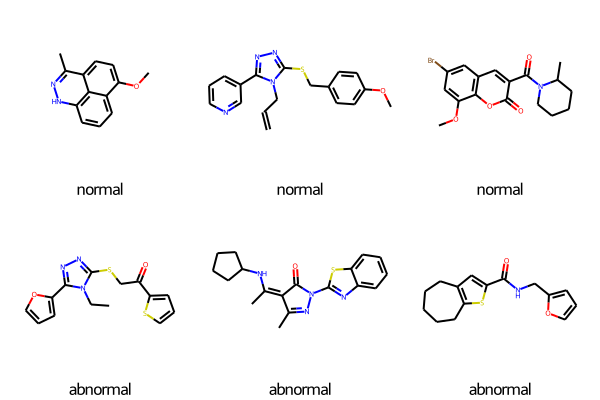

In [93]:
df_temp = datasets['MUV-692']['MorganFingerprint']
neg_sample = list(df_temp[df_temp['label'] == 1]['smiles'].sample(3))
pos_sample = list(df_temp[df_temp['label'] == -1]['smiles'].sample(3))
sample_smiles = neg_sample + pos_sample
sample_mols = [Chem.MolFromSmiles(m) for m in sample_smiles]
legends = ['normal'] * 3 + ['abnormal'] * 3
Draw.MolsToGridImage(sample_mols, legends=legends)

(결과적으로 눈으로는 구분할 수가 없네요...)  
Fingerprint나 Molecular Descriptor가 정상과 이상을 잘 구분하는 feature이길 기도합시다.

### Metric
정밀도, 위양성률, 정확도를 평가지표로 사용하였습니다.

In [3]:
def metric(pred, target, return_value = True, print_info=True):
    assert pred.shape[0] == target.shape[0]
    
    TP_idx = np.where(np.logical_and(pred==-1, target==-1))[0]
    TP = len(TP_idx)
    FP_idx = np.where(np.logical_and(pred==-1, target==1))[0]
    FP = len(FP_idx)
    FN_idx = np.where(np.logical_and(pred==1, target==-1))[0]
    FN = len(FN_idx)
    TN_idx = np.where(np.logical_and(pred==1, target==1))[0]
    TN = len(TN_idx)
    
    s = pd.Series([None]*pred.shape[0])
    s.iloc[TP_idx] = 'TP'
    s.iloc[FP_idx] = 'FP'
    s.iloc[TN_idx] = 'TN'
    s.iloc[FN_idx] = 'FN'
    
    precision = TP/(TP + FP)
    fpr = FP/(FP + TN)
    acc = (TP + TN)/(TP + FP + FN +TN)
    if print_info:
        print(f'Precision : {recall:.2f}')
        print(f'FPR       : {fpr:.2f}')
        print(f'Accuracy  : {acc:.2f}')
        
    if return_value:
        return precision, fpr, acc, list(s)

### Experiment Setting
- 4개의 타겟에 대해, 분자의 표현 방식 별로 3가지 평가지표를 산출합니다.
- 정상 데이터 80%를 훈련 데이터, 정상 데이터 20%와 이상 데이터 전부를 테스트 데이터로 사용합니다.
- __각 표현 방식에 따른 특징 벡터가 서로 독립인지 파악하기 위해__ 주성분 분석을 통해 orthogonal한 주성분 벡터 20개로 차원 축소할 경우, 어떠한 차이가 나는지 비교하였습니다.
- kernel의 종류와 $\nu$ 에 따른 3가지 평가지표의 변화를 트래킹하였습니다.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import product
import time

def OCSVM_experiment(datasets: dict,
                     representation: str,
                     target: str,
                     seed: int=7,
                     kernel: str='poly',
                     use_pca: bool=False,
                     nu: int=0.5,
                     print_info: bool=False,
                     **kwargs):
    
    np.random.seed(seed)
    random.seed(seed)
    
    df = datasets[target][representation]
    
    neg_features, pos_features, neg_labels, pos_labels = split_by_label(df)
    
    X_train, neg_features_test, _, neg_labels_test = train_test_split(neg_features,
                                                                      neg_labels,
                                                                      test_size=0.2,
                                                                      random_state=seed) 
    X_test = np.concatenate([neg_features_test, pos_features], axis=0)
    y_test = np.concatenate([neg_labels_test, pos_labels])
    
    if representation == 'Descriptors':
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    elif representation != 'MorganFingerprint':
        raise NotImplementedError
    
    variance = None
    if use_pca:
        pca = PCA(n_components=20)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
        variance = pca.explained_variance_ratio_.sum() * 100.0

    s_time = time.time()
    ocsvm = OneClassSVM(kernel=kernel, nu=nu)
    ocsvm.fit(X_train)
    elapsed_time = time.time() - s_time
    
    pred = ocsvm.predict(X_test)
    precision, fpr, acc, _ = metric(pred, y_test, return_value=True, print_info=print_info)
    
    record = {'target':target,
              'representation':representation,
              'seed':seed,
              'kernel':kernel,
              'elapsed_time': elapsed_time,
              'use_pca':use_pca,
              'Variance Ratio': variance,
              'nu': nu, 
              'precision':precision,
              'fpr':fpr,
              'accuracy':acc}
    
    return record

## Result
타겟, 표현방식, 커널, 규제 파라미터, 차원 축소 여부에 따른 학습 시간과 평가지표를 산출하였습니다.  
### 차원 축소에 따른 변수 설명력 비교 ###
- Molecular Descriptor__ : 주성분 분석을 통해 전체 분산의 약 82%를 커버하였습니다.  
- Morgan Fingerprint__ : 주성분 20개를 합하여도 약 20%의 분산만을 설명할 수 있습니다.  

__Morgan Fingerprint 보다 Molecular Descriptor 표현 방식이 정보의 중복이 더욱 많은 것을 알 수 있습니다.__  
__가설 1__: Fingerprint 표현 방식의 경우 변수간 상관성이 더 작기 때문에, 모델 구축을 하기 위해서는 더 많은 변수를 사용해야 할 것이라 추측하였습니다. 따라서 고정된 개수로 차원 축소를 할 경우, Fingerprint 표현 방식에 대한 모델 설명력이 감소할 것이라 예상하였습니다.  
__검증 방식__ : 차원 축소할 경우 Descriptor방식보다 Fingerprint 표현 방식의 성능 하락이 더욱 클 것이다.

In [95]:
from itertools import product
def comb_product(comb):
    return (dict(zip(comb.keys(), values)) for values in product(*comb.values()))

settings = {'datasets': [datasets],
            'seed': [777],
            'target': TARGET_LIST,
            'kernel':['poly', 'rbf'],
            'use_pca':[True, False],
            'nu':[0.2, 0.5, 0.8],
            'representation': ['Descriptors', 'MorganFingerprint']}

combinations = comb_product(settings)
records = []
for param in combinations:
    record = OCSVM_experiment(**param)
    records.append(record)
    
ocsvm_result_df_demo = pd.DataFrame.from_records(records)
print(ocsvm_result_df_demo.to_markdown(index=False))

| target   | representation    |   seed | kernel   |   elapsed_time | use_pca   |   Variance Ratio |   nu |   precision |      fpr |   accuracy |
|:---------|:------------------|-------:|:---------|---------------:|:----------|-----------------:|-----:|------------:|---------:|-----------:|
| MUV-692  | Descriptors       |    777 | poly     |       1.5226   | True      |          82.3551 |  0.2 |  0.0130435  | 0.2329   |   0.762356 |
| MUV-692  | MorganFingerprint |    777 | poly     |       0.960151 | True      |          27.5064 |  0.2 |  0.00984529 | 0.240766 |   0.753893 |
| MUV-692  | Descriptors       |    777 | poly     |       2.43579  | True      |          82.3551 |  0.5 |  0.0109819  | 0.523598 |   0.477319 |
| MUV-692  | MorganFingerprint |    777 | poly     |       2.15383  | True      |          27.5064 |  0.5 |  0.00822264 | 0.536252 |   0.463439 |
| MUV-692  | Descriptors       |    777 | poly     |       2.33142  | True      |          82.3551 |  0.8 |  0.0103907  | 0.

### 학습 시간에 대한 비교 ###
차원 축소하지 않은 MorganFingerprint 표현 방식의 경우 학습 시간이 다른 조합 대비 40~80배 느린 것을 알 수 있습니다.

- 만약 해당 조합과 나머지 조합에 대한 평가 지표의 차이가 크지 않을 경우, __MorganFingerprint를 사용하는 것은 비효율적__ 일 것입니다.

In [14]:
print(ocsvm_result_df_demo.groupby(['representation', 'use_pca', 'kernel'])['elapsed_time'].agg(['mean', 'std']).reset_index().to_markdown())

|    | representation    | use_pca   | kernel   |     mean |       std |
|---:|:------------------|:----------|:---------|---------:|----------:|
|  0 | Descriptors       | False     | poly     |  3.90271 |  1.21207  |
|  1 | Descriptors       | False     | rbf      |  4.35763 |  1.69701  |
|  2 | Descriptors       | True      | poly     |  2.13819 |  0.415311 |
|  3 | Descriptors       | True      | rbf      |  2.24817 |  0.86722  |
|  4 | MorganFingerprint | False     | poly     | 84.5737  | 33.8131   |
|  5 | MorganFingerprint | False     | rbf      | 83.1178  | 33.6279   |
|  6 | MorganFingerprint | True      | poly     |  1.85569 |  0.639679 |
|  7 | MorganFingerprint | True      | rbf      |  2.24636 |  0.859456 |


### 조합에 대한 평가 지표 비교 ###
4개의 타겟에 대한 평균과 표준편차를 구하여 조합별로 비교하였습니다

In [27]:
summary = ocsvm_result_df_demo.groupby(['representation', 'use_pca', 'nu', 'kernel'])['precision', 'fpr', 'accuracy'].agg(['mean', 'std']).reset_index()
summary

representation use_pca   nu kernel precision                 fpr  \
                                               mean       std      mean   
0         Descriptors   False  0.2   poly  0.009576  0.004166  0.264017   
1         Descriptors   False  0.2    rbf  0.008290  0.002930  0.203540   
2         Descriptors   False  0.5   poly  0.009450  0.002542  0.519640   
3         Descriptors   False  0.5    rbf  0.009748  0.001783  0.502630   
4         Descriptors   False  0.8   poly  0.010055  0.001591  0.806529   
5         Descriptors   False  0.8    rbf  0.009521  0.000772  0.807891   
6         Descriptors    True  0.2   poly  0.009861  0.003308  0.231927   
7         Descriptors    True  0.2    rbf  0.005863  0.001563  0.202690   
8         Descriptors    True  0.5   poly  0.008764  0.002495  0.510620   
9         Descriptors    True  0.5    rbf  0.009275  0.001744  0.501603   
10        Descriptors    True  0.8   poly  0.009769  0.002214  0.805092   
11        Descriptors    True  0.8    rbf  0.009375  0.000550  0.802264   
12  MorganFingerprint   False  0.2   poly  0.010213  0.001411  0.214708   
13  MorganFingerprint   False  0.2    rbf  0.008506  0.005694  0.199200   
14  MorganFingerprint   False  0.5   poly  0.010289  0.003785  0.508655   
15  MorganFingerprint   False  0.5    rbf  0.009714  0.002637  0.503058   
16  MorganFingerprint   False  0.8   poly  0.010408  0.002357  0.800689   
17  MorganFingerprint   False  0.8    rbf  0.009928  0.001034  0.799796   
18  MorganFingerprint    True  0.2   poly  0.010502  0.002677  0.232948   
19  MorganFingerprint    True  0.2    rbf  0.007073  0.000239  0.191769   
20  MorganFingerprint    True  0.5   poly  0.009712  0.001288  0.530489   
21  MorganFingerprint    True  0.5    rbf  0.009512  0.001674  0.488082   
22  MorganFingerprint    True  0.8   poly  0.010439  0.000557  0.817165   
23  MorganFingerprint    True  0.8    rbf  0.010057  0.000845  0.797938   

              accuracy            
         std      mean       std  
0   0.007541  0.731492  0.007306  
1   0.012773  0.790549  0.012876  
2   0.012044  0.480675  0.012261  
3   0.011193  0.497524  0.011388  
4   0.007179  0.199734  0.007504  
5   0.003945  0.197962  0.004056  
6   0.003859  0.763020  0.003766  
7   0.018588  0.790888  0.018811  
8   0.010036  0.489191  0.009564  
9   0.010008  0.498288  0.010567  
10  0.010045  0.200904  0.010859  
11  0.005145  0.203366  0.004860  
12  0.012625  0.779996  0.012753  
13  0.006701  0.794851  0.007693  
14  0.010202  0.491896  0.010093  
15  0.009747  0.497104  0.008949  
16  0.014502  0.205787  0.012600  
17  0.005441  0.206237  0.005310  
18  0.009128  0.762178  0.009265  
19  0.006765  0.801865  0.006724  
20  0.006120  0.470178  0.006082  
21  0.006153  0.511675  0.005591  
22  0.009782  0.189618  0.009894  
23  0.008992  0.208159  0.008991

### 결과 요약 ###
$\nu$ 에 따른 정밀도, 위양성률, 정확도의 추이를 살펴보았습니다.
- $\nu$ 에 따른 각 평가지표의 변동성이 큰 걸로 보아, 정상 데이터와 이상 데이터의 영역이 잘 구분되지 않았다고 판단 할 수 있습니다. 따라서 __두 가지 표현 방식 모두가 MUV 데이터의 정상/이상을 판단하는데 도움이 되지 않는 것을 알 수 있습니다.__  
- MUV데이터에 대해 개별 표현 방식에 따른 표현력의 우위가 없는 것을 알 수 있습니다. precision의 경우 차이가 커보이지만, __y축 스케일이 매우 작은 것을 유의해서 봐야합니다.__  
- __가설1__(Fingerprint 방식의 경우 차원 축소로 인한 성능차이가 클 것)이 기각되었음을 알 수 있습니다. __개별 변수 간의 상관성은 없지만, 각 변수가 MUV의 타겟을 설명하는 설명력은 존재하지 않는다고 판단하였습니다.__

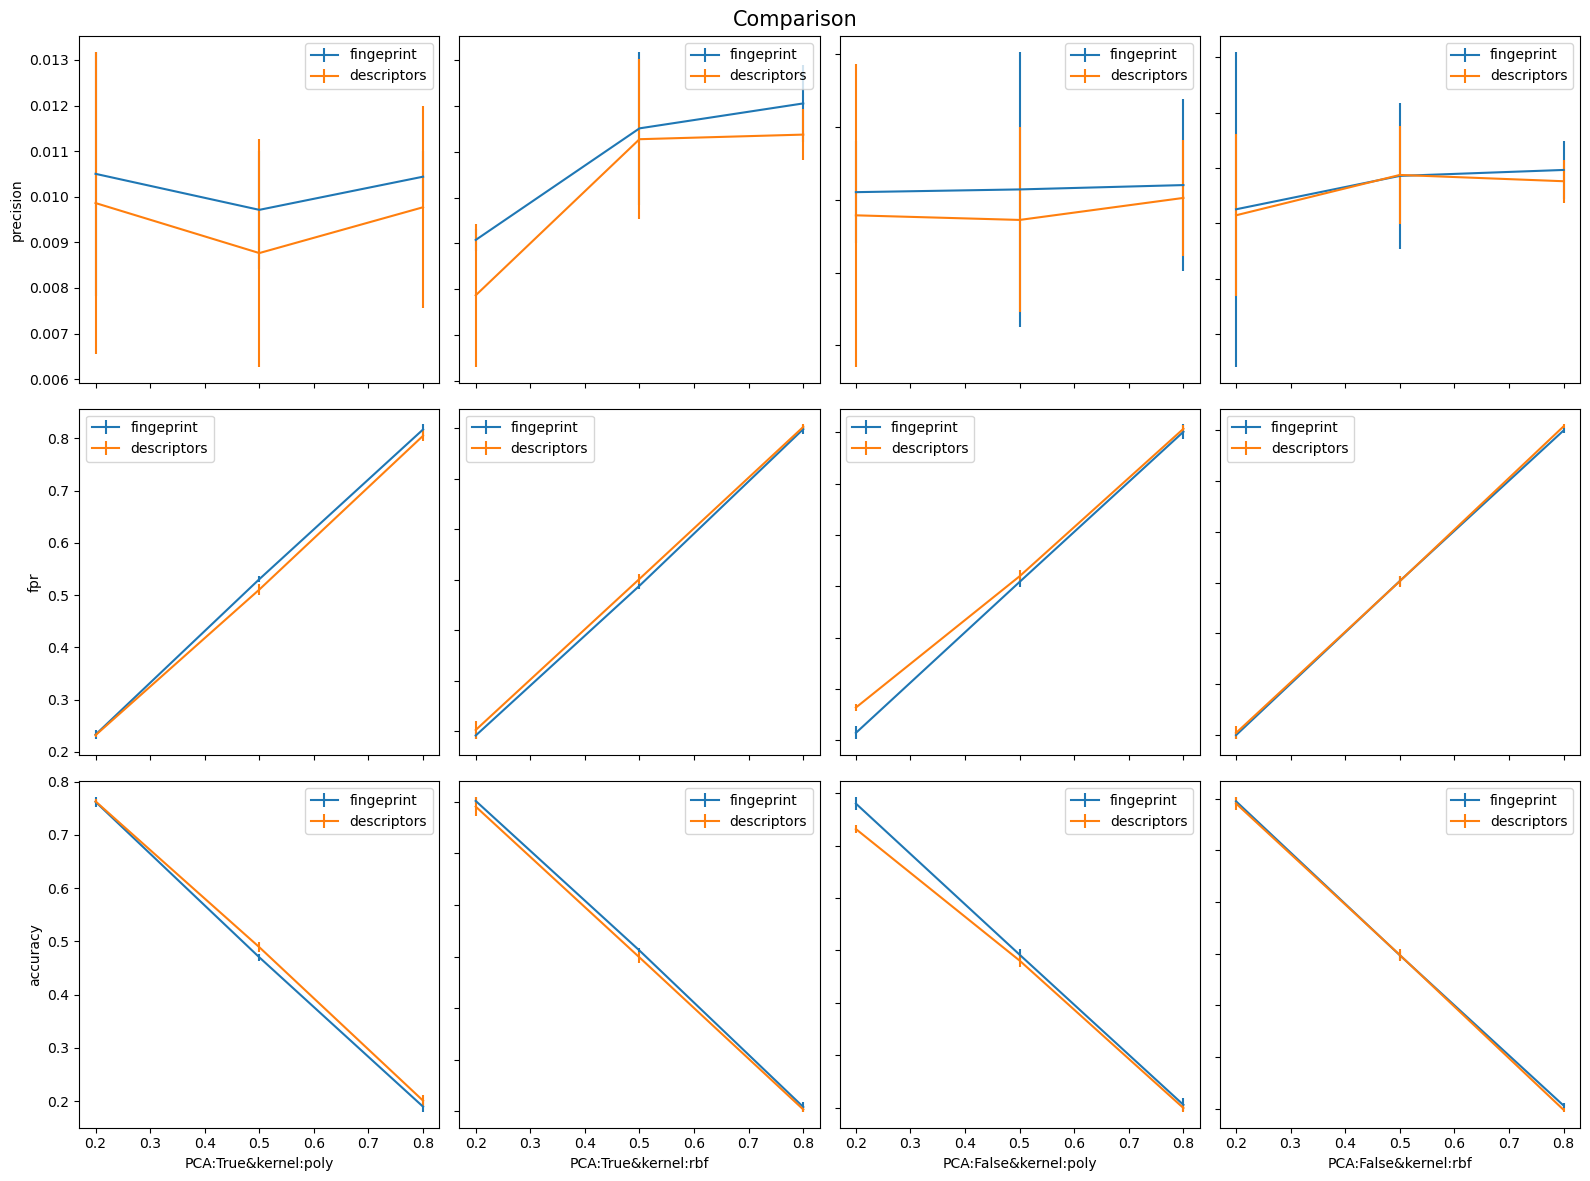

In [67]:
keys = list(product(*[[True, False], ['poly', 'rbf']]))

fig, axs = plt.subplots(3, 4, figsize=(16, 12))

keys = list(product(*[[True, False], ['poly', 'rbf']]))
for j, k in enumerate(keys):
    for i, m in enumerate(['precision', 'fpr', 'accuracy']):
        
        use_pca, kernel = k
        
        
        summary_desc = summary[(summary['representation'] == 'Descriptors')&(summary['use_pca'] == use_pca)&(summary['kernel'] == kernel)][m]
        summary_fp = summary[(summary['representation'] == 'MorganFingerprint')&(summary['use_pca'] == use_pca)&(summary['kernel'] == kernel)][m]
        nu = list(summary['nu'].unique())
        desc_mean = list(summary_desc['mean'])
        desc_std = list(summary_desc['std'])
        
        fp_mean = list(summary_fp['mean'])
        fp_std = list(summary_fp['std'])
        
        use_pca = str(use_pca)
        subtitle = f'PCA:{use_pca}&kernel:{kernel}'
        
        axs[i, j].errorbar(nu, fp_mean, yerr=fp_std, label='fingeprint')
        axs[i, j].errorbar(nu, desc_mean, yerr=desc_std, label='descriptors')
        axs[i, j].legend()
        
        axs[i, j].set(xlabel=subtitle, ylabel=m)
        axs[i, j].label_outer()
fig.suptitle('Comparison', fontsize=15)
fig.tight_layout()

### 표현 방식에 따른 정상/이상 데이터 시각화 ###
각 플롯 별 왼쪽 그림은 학습(정상)데이터에 대한 결정 경계, 오른쪽 그림은 테스트 데이터(정상 + 이상)에 대한 결정 경계를 시각화하였습니다.
- 테스트 데이터에 대한 시각화를 통해 두 표현 방식에 사용되었던 변수는 MUV의 타겟 단백질을 구분할 설명력이 없다는 것을 알 수 있습니다.

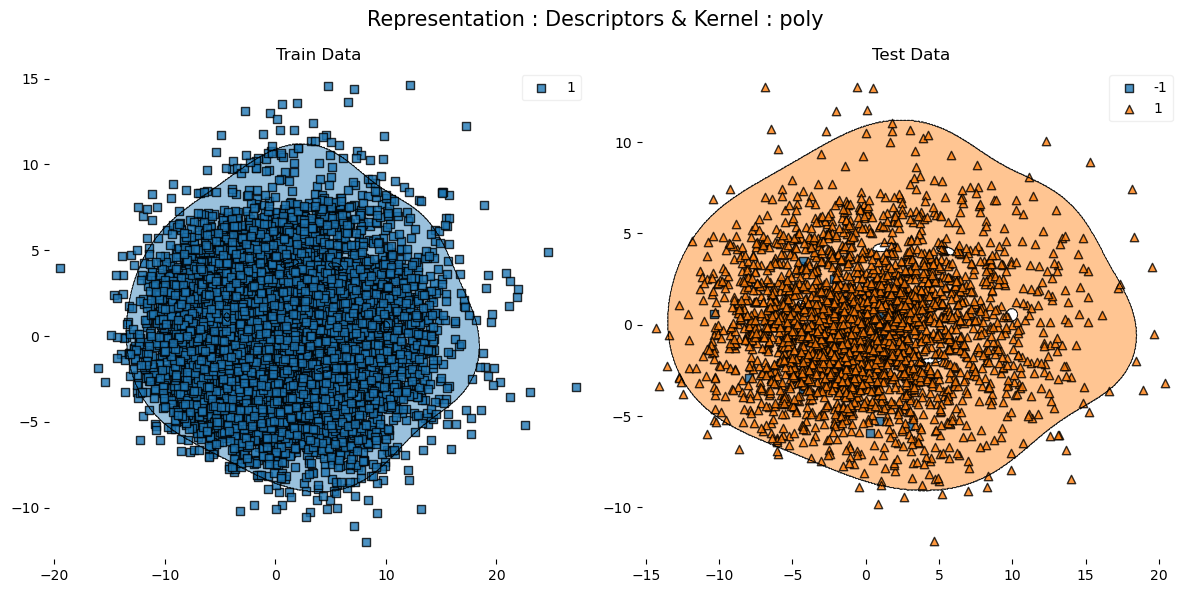

In [73]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

def plot_ocsvm(dataset: dict, target:str, kernel:kernel, nu:int, representation='Descriptors'):
    df = datasets[target][representation]

    neg_features, pos_features, neg_labels, pos_labels = split_by_label(df)

    X_train, neg_features_test, _, neg_labels_test = train_test_split(neg_features,
                                                                    neg_labels,
                                                                    test_size=0.2,
                                                                    random_state=777) 
    X_test = np.concatenate([pos_features, neg_features_test], axis=0)
    y_test = np.concatenate([pos_labels, neg_labels_test])
    
    if representation == 'Descriptors':
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    elif representation != 'MorganFingerprint':
        raise NotImplementedError
    
    pca = PCA(n_components=2)
    
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    
    ocsvm = OneClassSVM(kernel='rbf', nu=nu)
    ocsvm.fit(X_train)
    pred = ocsvm.predict(X_test)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.title.set_text("Train Data")
    plot_decision_regions(X_train, np.ones(X_train.shape[0], dtype=int), clf=ocsvm, ax=ax1)
    
    ax2.title.set_text("Test Data")
    plot_decision_regions(X_test, y_test, clf=ocsvm, ax=ax2)
    fig.suptitle(f'Representation : {representation} & Kernel : {kernel}', fontsize=15)
    fig.tight_layout()

plot_ocsvm(datasets, 'MUV-846', 'poly', 0.02)

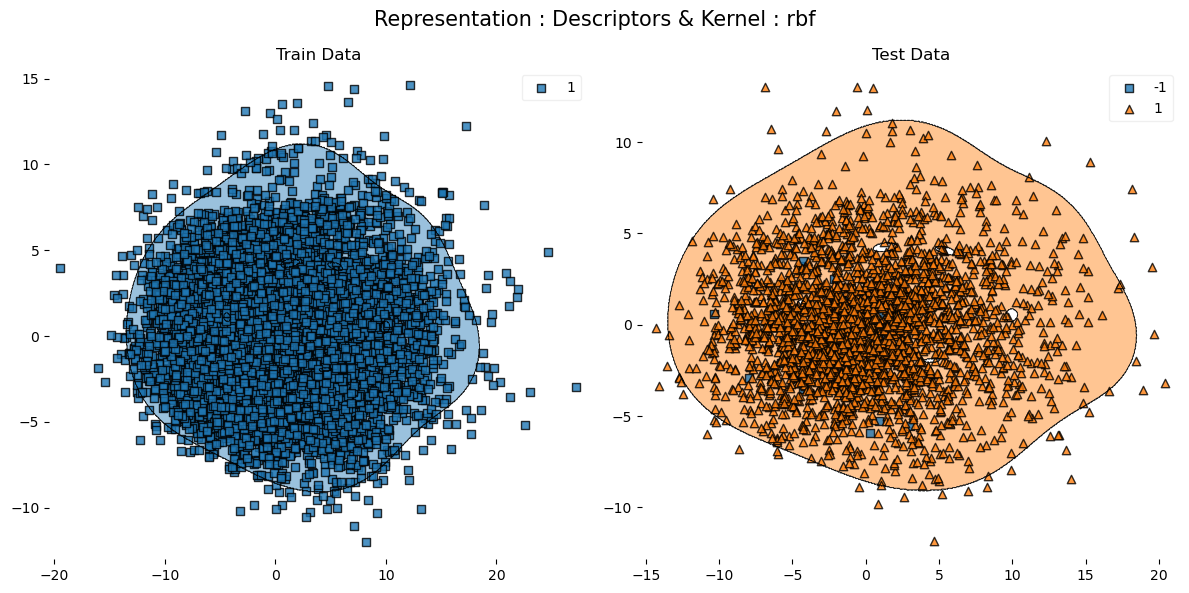

In [74]:
plot_ocsvm(datasets, 'MUV-846', 'rbf', 0.02)

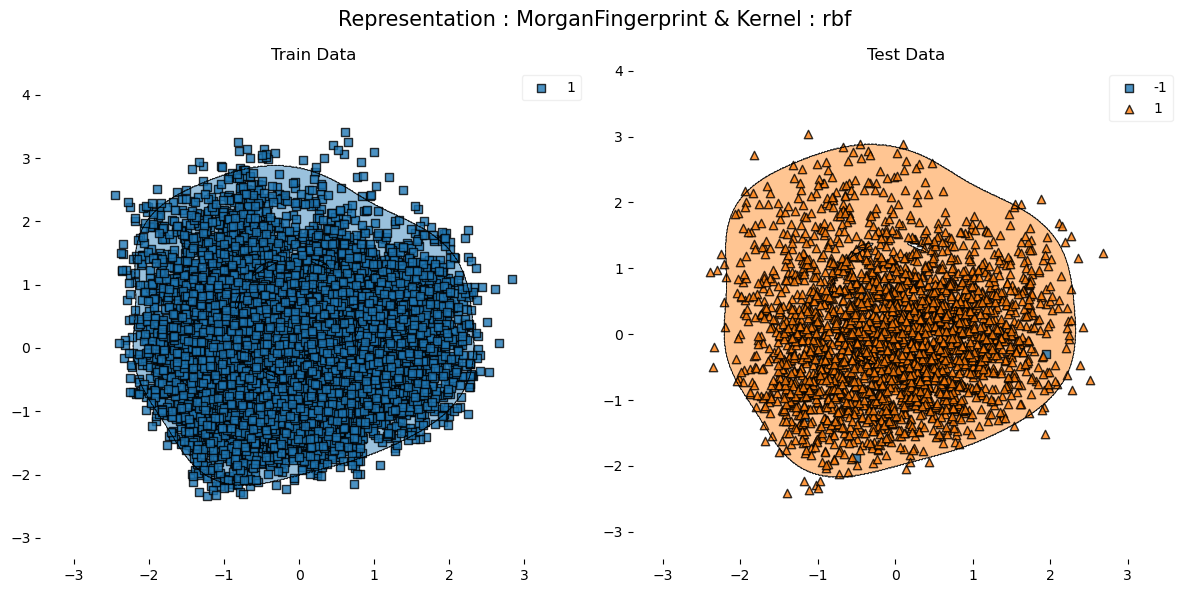

In [75]:
plot_ocsvm(datasets, 'MUV-846', 'rbf', 0.02,'MorganFingerprint')

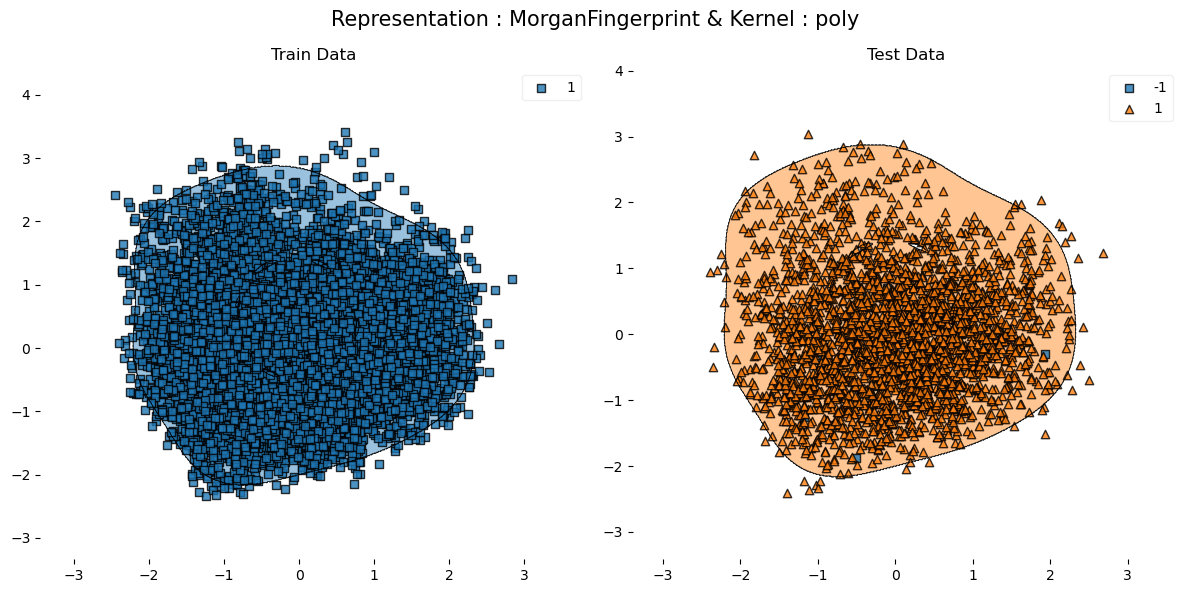

In [76]:
plot_ocsvm(datasets, 'MUV-846', 'poly', 0.02,'MorganFingerprint')

## To Do - How to Improve??
본 튜토리얼은 분자를 표현하는 두가지 방식을 통해 OCSVM으로 이상 데이터를 검출하는 프로세스를 진행하였습니다. 하지만 아쉽게도, MUV 데이터셋의 타겟에 대해 두 가지 표현 방식은 좋은 설명력을 가지지 못하는 것을 확인할 수 있습니다.
- 두 표현 방식을 통한 입력 변수가 정상/이상 판단에 설명력이 없습니다. 따라서 입력 변수를 바꾸지 않는한 Isolation Forest 등의 다른 모델을 사용하여도 이상치 탐지가 잘 되지 않을 것이라 생각합니다.
- Morgan Fingerprint나 Molecular Descriptors와 같은 정형 데이터 방식이 아닌 __그래프 데이터__ 를 입력으로 하는 __GNN 기반 이상치 탐지__ 를 고려해볼 수 있습니다. 차후 분석에서는 분자를 그래프로 표현한 후, __Masked Node Prediction__ 을 통해 정상 데이터를 학습 시킨 후, 복원 오차를 통해 이상치를 탐지해볼 계획입니다.
